## Выполнили: Грудинин Михаил и Климовский Дмитрий 23Б16

# Лабораторная работа №3

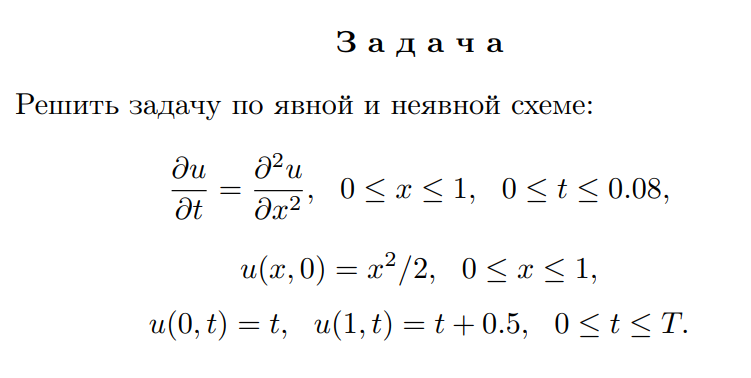

Для решения данной задачи используются два метода: явная и неявная разностные схемы.
Для явной схемы дискретизация уравнения теплопроводности имеет следующий вид:
$$
u_i^{n+1} = u_i^n + \frac{\Delta t}{(\Delta x)^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$
где $ \Delta t $ и $ \Delta x $ — шаги по времени и пространству соответственно, а $ u_i^n $ — приближённое решение в узле $ x_i $ в момент времени $ t_n $.

Для неявной схемы необходимо решить систему уравнений на каждом временном шаге:
$$
u_i^{n+1} - \frac{\Delta t}{(\Delta x)^2}(u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}) = u_i^n
$$
Эта система решается с использованием метода прогонки для трёхдиагональных матриц.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Для отрисовки графиков
%matplotlib inline

In [2]:
# Задаем параметры задачи
L = 1.0   # Длина стержня
T = 0.08  # Общее время
Nx = 10   # Число пространственных шагов
Nt = 100  # Число временных шагов

In [3]:
# Шаг по пространству и шаг по времени
dx = L / Nx
dt = T / Nt

In [4]:
# Коэффициент устойчивости для явной схемы
alpha = dt / dx**2

In [5]:
# Проверим условие на \( \alpha \), чтобы убедиться в устойчивости явной схемы
assert alpha <= 0.5, "Не выполнено условие устойчивости: alpha <= 0.5"

In [6]:
# Создаем массивы для пространственных и временных координат
x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T, Nt+1)

In [7]:
# Начальное условие
u_initial = (x**2) / 2

In [8]:
# Граничные условия
def u_boundary_left(t):
    return t

def u_boundary_right(t):
    return t + 0.5

In [9]:
# Инициализация массивов для явной и неявной схем
u_explicit = np.zeros((Nx+1, Nt+1))  # Явная схема
u_implicit = np.zeros((Nx+1, Nt+1))  # Неявная схема


In [10]:
# Применение начальных условий для обеих схем
u_explicit[:, 0] = u_initial
u_implicit[:, 0] = u_initial

In [11]:
# Применение граничных условий для обеих схем
u_explicit[0, :] = u_boundary_left(t)
u_explicit[-1, :] = u_boundary_right(t)

u_implicit[0, :] = u_boundary_left(t)
u_implicit[-1, :] = u_boundary_right(t)

На каждом временном шаге вычисляем значения функции $ u $ для внутренних точек сетки, используя явную разностную схему.


In [12]:
for n in range(0, Nt):
    for i in range(1, Nx):
        u_explicit[i, n+1] = u_explicit[i, n] + alpha * (u_explicit[i+1, n] - 2*u_explicit[i, n] + u_explicit[i-1, n])

### Реализация неявной схемы

Решаем систему уравнений с трёхдиагональной матрицей методом прогонки.


In [13]:
def Progonka(a, b, c, d):
    """
    Метод прогонки для решения трёхдиагональной системы уравнений.
    Параметры:
    a, b, c - диагонали матрицы системы.
    d - правая часть системы.
    """
    n = len(d)
    c_star = np.zeros(n-1)
    d_star = np.zeros(n)
    
    # Прямой ход
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_star[i-1]
        c_star[i] = c[i] / denom
        d_star[i] = (d[i] - a[i-1] * d_star[i-1]) / denom
    
    d_star[-1] = (d[-1] - a[-2] * d_star[-2]) / (b[-1] - a[-2] * c_star[-2])
    
    # Обратный ход
    x = np.zeros(n)
    x[-1] = d_star[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    
    return x

In [14]:
# Диагональные элементы для метода прогонки
a = -alpha * np.ones(Nx-1)
b = (1 + 2 * alpha) * np.ones(Nx-1)
c = -alpha * np.ones(Nx-1)

In [15]:
# Реализация неявной схемы
for n in range(0, Nt):
    d = u_implicit[1:Nx, n]
    d[0] += alpha * u_boundary_left(t[n+1])
    d[-1] += alpha * u_boundary_right(t[n+1])
    u_implicit[1:Nx, n+1] = Progonka(a, b, c, d)

### Построение графиков

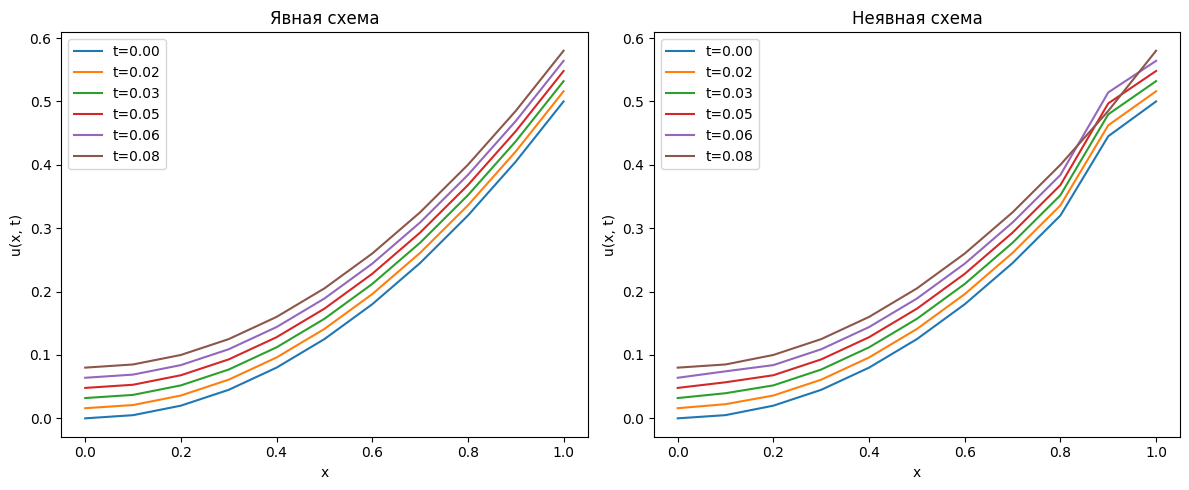

In [16]:
# Визуализируем результаты для явной и неявной схем.

plt.figure(figsize=(12, 5))

# График для явной схемы
plt.subplot(1, 2, 1)
for n in range(0, Nt+1, Nt//5):
    plt.plot(x, u_explicit[:, n], label=f"t={t[n]:.2f}")
plt.title('Явная схема')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()

# График для неявной схемы
plt.subplot(1, 2, 2)
for n in range(0, Nt+1, Nt//5):
    plt.plot(x, u_implicit[:, n], label=f"t={t[n]:.2f}")
plt.title('Неявная схема')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()

plt.tight_layout()
plt.show()

На графиках представлены решения уравнения теплопроводности с использованием явной и неявной схем.

- **Явная схема** (слева): показаны профили функции $ u(x, t) $ в разные моменты времени.
- **Неявная схема** (справа): аналогично представлены профили функции $ u(x, t) $ на тех же временных шагах.

Обе схемы дают схожие результаты, так как обе корректно описывают распространение тепла в системе.